<a href="https://colab.research.google.com/github/prudhvirajboddu/TensorFlowML/blob/master/Classification_of_Flowers_using_a_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
print(tf.__version__)

2.2.0-rc3




> Adding TPU



In [0]:
# Authenticate yourself to use the TPUs
import os

IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

In [3]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.78.14.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.78.14.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.78.14.194:8470']
Number of accelerators:  8


**Downloading the flowers dataset as  Local data**

In [0]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [5]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['roses', 'tulips', 'sunflowers', 'daisy', 'dandelion'],
      dtype='<U10')

*Hyperparameters*

In [0]:
BATCH_SIZE = 32*strategy.num_replicas_in_sync
IMG_HEIGHT = 224
IMG_WIDTH = 224

**Using Datagenerators**

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=40,
                                                                  horizontal_flip=True,
                                                                  shear_range=0.2,
                                                                  zoom_range=0.1,
                                                                  fill_mode='nearest',
                                                                  validation_split=0.3)

In [8]:
train_data_gen=image_generator.flow_from_directory(str(data_dir),
                                                   target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   subset='training',
                                                   classes=list(CLASS_NAMES)
                                                   )

Found 2572 images belonging to 5 classes.


In [9]:
valid_data_gen=image_generator.flow_from_directory(str(data_dir),
                                                   target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                   class_mode='categorical',
                                                   shuffle=False,
                                                   batch_size=BATCH_SIZE,
                                                   subset='validation',
                                                   classes=list(CLASS_NAMES)
                                                   )

Found 1098 images belonging to 5 classes.


In [10]:
STEPS_PER_EPOCH=np.ceil(len(train_data_gen.filenames)/BATCH_SIZE)
VALIDATION_STEPS=np.ceil(len(valid_data_gen.filenames)/BATCH_SIZE)
print(STEPS_PER_EPOCH , VALIDATION_STEPS)

11.0 5.0


In [0]:
#@title Display Utilities (Displaying a batch of images)
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
train_img_batch,train_label_batch = next(train_data_gen) 
test_img_batch,test_label_batch=next(valid_data_gen)   #Iterating over the Generator

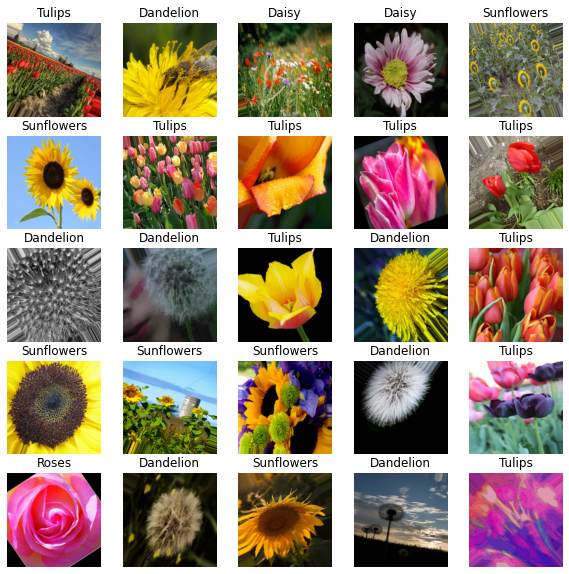

In [13]:
show_batch(train_img_batch, train_label_batch)

In [0]:
train_label_batch,test_label_batch=train_label_batch.astype('uint32'),test_label_batch.astype('uint32') 
#To change the dtype of labels as it supports only "uint32" in case of TPU

**Using tf.data API for increasing the speed of training**

In [0]:
train_ds=tf.data.Dataset.from_tensor_slices((train_img_batch,train_label_batch))
test_ds=tf.data.Dataset.from_tensor_slices((test_img_batch,test_label_batch))

In [0]:
train_ds = train_ds.shuffle(1024).repeat().batch(BATCH_SIZE).cache()
test_ds = test_ds.repeat().batch(BATCH_SIZE).cache()

**Model creation**

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [0]:
def create_model():
    model = Sequential([
        Conv2D(64,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
        Conv2D(32,activation='relu'),
        Flatten(),
        Dense(128,activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [19]:
# Train on TPUs
import time 

with strategy.scope():
    model = create_model()

model.summary()
start = time.time()
model.fit(train_ds,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_data=test_ds,
          validation_steps=VALIDATION_STEPS,
          epochs=5)
print("It took {} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 788544)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                50466880  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 50,468,997
Trainable params: 50,468,997
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
11/11 [==============================] - 16s 1s/step - loss: 20.0653 - accuracy: 0.2518 - val_loss:

*Plotting LOSS and ACCURACY*

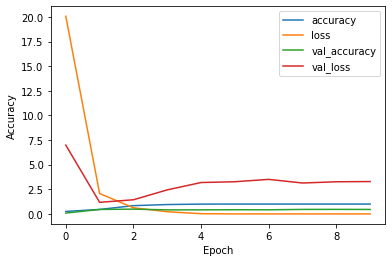

In [20]:
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['loss'],label='loss')
plt.plot(model.history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(model.history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')